<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/06-common-design-building-blocks/02_batch_and_layer_normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Batch/Layer Normalization

We will discuss five new methods that work for feed-forward models and
one new improvement to RNNs. We introduce the first five methods roughly in the
order that they were invented, as each tends to use the preceding techniques in their
design. 

Individually, they improve accuracy and speed up training; but combined, they
are greater than the sum of their parts.

1. Better activation function
2. Batch/Layer normalization
3. Skip connections and 1 x 1 convolution
4. Residual connections
5. Long short-term memory (LSTM) layer

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import accuracy_score

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from idlmam import train_network, Flatten, weight_reset, set_seed
from idlmam import LanguageNameDataset, pad_and_pack, EmbeddingPackable, LastTimeStep, LambdaLayer

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

##Dataset

We use the
Fashion-MNIST dataset because it is slightly more challenging while retaining the same
size and shape as the original MNIST corpus, which will let us accomplish some testing
in a reasonable time.

In [ ]:
B = 128

train_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./data", train=True, transform=transforms.ToTensor(), download=True)

training_loader = DataLoader(train_data, batch_size=B, shuffle=True)
testing_loader = DataLoader(test_data, batch_size=B)

##Baseline model

Let’s define some basic hyperparameters.

In [7]:
W, H = 28, 28
D = 28 * 28       # input size
n = 188           # Hidden layer size
C= 1              # How many channels are in the input?
n_filters = 32    # filters per convolutional layer
classes = 10      # How many classes are there?

In [8]:
fc_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D,  n), 
  nn.Tanh(), #First hidden layer 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n,  n), nn.Tanh()) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [9]:
cnn_model = nn.Sequential(
  nn.Conv2d(C, n_filters, 3, padding=1),             
  nn.Tanh(),
  nn.Conv2d(n_filters, n_filters, 3, padding=1),     
  nn.Tanh(),
  nn.Conv2d(n_filters, n_filters, 3, padding=1),     
  nn.Tanh(),
  nn.MaxPool2d((2,2)),
  
  nn.Conv2d(  n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(2*n_filters, 2*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.MaxPool2d((2,2)),

  nn.Conv2d(2*n_filters, 4*n_filters, 3, padding=1), 
  nn.Tanh(),
  nn.Conv2d(4*n_filters, 4*n_filters, 3, padding=1), 
  nn.Tanh(),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

We use our new train_network function to train all of the models.

In [ ]:
loss_func = nn.CrossEntropyLoss()

fc_results = train_network(fc_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [ ]:
cnn_results = train_network(cnn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)

In [12]:
fc_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,16.362427,0.633577,0.461121,0.766650,0.837750
1,1,23.130142,0.434101,0.413325,0.845150,0.849067
2,2,29.996485,0.391224,0.358891,0.857450,0.867400
3,3,36.666134,0.363648,0.327916,0.868283,0.877617
4,4,43.404690,0.346689,0.332774,0.873750,0.883317


In [13]:
cnn_results.head()

,epoch,total time,train loss,test loss,train Acc,test Acc
0,0,17.070750,0.491520,0.315718,0.82165,0.885933
1,1,30.251983,0.320271,0.300401,0.88580,0.892483
2,2,42.973555,0.283402,0.227856,0.90060,0.918867
3,3,55.691778,0.256085,0.238842,0.90905,0.912200
4,4,68.476340,0.246041,0.245748,0.91435,0.917450


Let’s be explicit and tell Python we are finished so we can get back the GPU memory.

In [14]:
del fc_model
del cnn_model

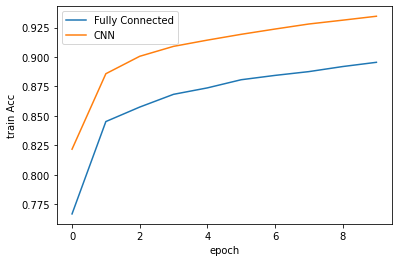

In [15]:
sns.lineplot(x="epoch", y="train Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="train Acc", data=cnn_results, label="CNN")

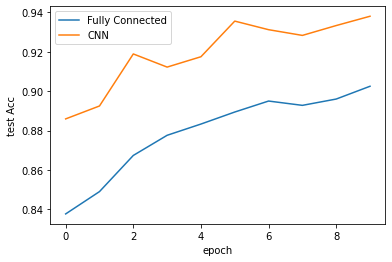

In [16]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="Fully Connected")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")

##ReLU Baseline

In [17]:
# How much I want the LeakyReLU to "leak" by. Anything in [0.01, 0.3] would have been fine.
leak_rate = 0.1

fc_relu_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D,  n), 
  nn.LeakyReLU(leak_rate), 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n,  n), nn.LeakyReLU(leak_rate)) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [18]:
def cnn_layer(in_filters, out_filters=None, kernel_size=3):
  """
  in_filters: how many channels are coming into the layer
  out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
  kernel_size: how large the kernel should be
  """
  if out_filters is None:
    # This is a common pattern, so lets automate it as a default if not asked
    out_filters = in_filters 
  # padding to stay the same size
  padding = kernel_size // 2
  # Combine the layer and activation into a single unit
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.LeakyReLU(leak_rate)
  )

In [19]:
cnn_relu_model = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters),
  cnn_layer(n_filters),
  nn.MaxPool2d((2,2)),
  
  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters),
  cnn_layer(2 * n_filters),
  nn.MaxPool2d((2,2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

In [ ]:
fc_relu_results = train_network(fc_relu_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_relu_model

In [ ]:
cnn_relu_results = train_network(cnn_relu_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_relu_model

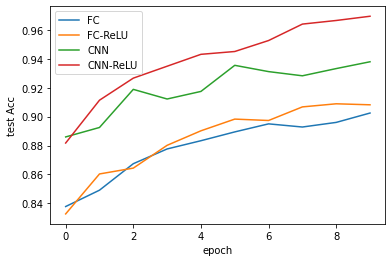

In [22]:
sns.lineplot(x="epoch", y="test Acc", data=fc_results, label="FC")
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_results, label="CNN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")

##Normalization layers

Before you start feeding the matrix $X$ into your favorite ML algorithm, you usually
normalize or standardize the features in some way. This could be making sure the values
are all within the range of `[0, 1]`, or subtracting the mean $\mu$ and dividing by the standard
deviation $\sigma$.

By performing normalization or standardization, we
ensure that our data is in a reasonable numeric range (–1 to 1 is a good place to be),
making it easier for our optimization algorithms to run.

We’ll talk about two normalization layers that
are the most widely used: batch and layer.

###Batch normalization

The first and most popular type of normalization layer is batch normalization (BN). 

BN is applied differently depending on the structure of the input data.

If we are working with
fully connected layers (PyTorch dimension `(B,D)`), we take the average and standard
deviation of the feature values `D` over the `B` items in the batch. 

Hence, we normalize
over the data features in a given batch. This means $\mu$, $\sigma$, 
$\gamma$, and $\beta$ have a shape of `(D)`,
and each item in the batch is normalized by the mean and standard deviation of just
that batch of data.

What if we have one-dimensional data of shape `(B,C,D)`? 

In this case, we normalize
the channels over the batch. This means $\mu$, $\sigma$, 
$\gamma$, and $\beta$ each have a shape of `(C)`.

This is
because we want to treat each of the `D` values in a channel as having the same nature
and structure, so the average is over the `BxD` values in the channel across all `B` batches.

What if we have 2D data of shape `(B, C, W, H)`? 

Similar to the 1D case $\mu$, $\sigma$, 
$\gamma$, and $\beta$ have a shape of `(C)`.

For any z-dimensional structured data where we have channels, we always
use BN over the channels.

Let's train the model with batch normalization.

In [23]:
fc_bn_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D, n), 
  nn.BatchNorm1d(n),
  nn.LeakyReLU(leak_rate), 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n, n), nn.BatchNorm1d(n), nn.LeakyReLU(leak_rate)) for _ in range(5)], 
  nn.Linear(n, classes),
)

In [24]:
def cnn_layer(in_filters, out_filters=None, kernel_size=3):
  """
  in_filters: how many channels are coming into the layer
  out_filters: how many channels this layer should learn / output, or `None` if we want to have the same number of channels as the input.
  kernel_size: how large the kernel should be
  """
  if out_filters is None:
    # This is a common pattern, so lets automate it as a default if not asked
    out_filters = in_filters 
  # padding to stay the same size
  padding = kernel_size // 2
  # Combine the layer and activation into a single unit
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.BatchNorm2d(out_filters),  # The only change: adding BatchNorm2d after our convolution
    nn.LeakyReLU(leak_rate)
  )

In [25]:
cnn_bn_model = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters),
  cnn_layer(n_filters),
  nn.MaxPool2d((2,2)),
  
  cnn_layer(n_filters, 2 * n_filters),
  cnn_layer(2 * n_filters),
  cnn_layer(2 * n_filters),
  nn.MaxPool2d((2,2)),

  cnn_layer(2 * n_filters, 4 * n_filters),
  cnn_layer(4 * n_filters),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

We are ready to train both models.

In [ ]:
fc_bn_results = train_network(fc_bn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_bn_model

In [ ]:
cnn_bn_results = train_network(cnn_bn_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_bn_model

Let’s compare it with baseline model.

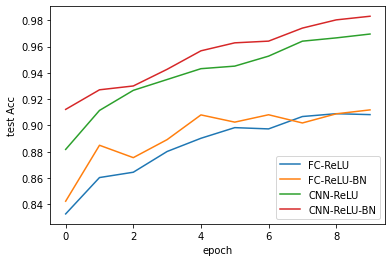

In [28]:
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=fc_bn_results, label="FC-ReLU-BN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_bn_results, label="CNN-ReLU-BN")

Why does BN work so well?

Since normalizing helps to ensure that our literal numeric values after each
layer are in a generically “good” range; and through $\gamma$
and $\beta$, the network can decide precisely where that range is.

###Layer normalization

The `nn.LayerNorm` class takes a single argument that is a list of integers. If you are
working on fully connected layers with tensors of shape `(B,D)`, you use `[D]` as the list,
giving you `nn.LayerNorm([D])` as the layer construction.

In [29]:
fc_ln_model = nn.Sequential(
  nn.Flatten(),
  nn.Linear(D, n), 
  nn.LayerNorm([n]),
  nn.LeakyReLU(leak_rate), 
  #Now that each remaining layer has the same input/output sizes, we can make them with a list unpacking
  *[nn.Sequential(nn.Linear(n, n), nn.LayerNorm([n]), nn.LeakyReLU(leak_rate)) for _ in range(5)], 
  nn.Linear(n, classes),
)

Why does LN take a list of integers? 

This list tells LN, from right to left, which values to
average over. So if we have a 2D problem with tensors of shape `(B, C,W,H)`, we give
LN the last three dimensions as a list `[C, W, H]`. That covers all the features, which is
what we want LN to normalize over. 

This makes LN a little trickier for CNNs because
we also need to pay attention to how large the width and height are, and they change every time we apply max pooling.

We add a pool_factor
argument that keeps track of how many times pooling has been applied.

After, is an
LN object with a list `[out_filters, W//(2**pool_factor), H//(2**pool_factor)]` where we shrink with width and height based on how many times pooling has been applied.

In [30]:
def cnn_layer(in_filters, out_filters=None, pool_factor=0, kernel_size=3):
  if out_filters is None:
    # This is a common pattern, so lets automate it as a default if not asked
    out_filters = in_filters 
  # padding to stay the same size
  padding = kernel_size // 2
  # Combine the layer and activation into a single unit
  return nn.Sequential(
    nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding),
    nn.LayerNorm([out_filters, W // (2 ** pool_factor), H // (2 ** pool_factor)]),  # The only change: adding LayerNorm after our convolution
    nn.LeakyReLU(leak_rate)
  )

In [31]:
cnn_ln_model = nn.Sequential(
  cnn_layer(C, n_filters),
  cnn_layer(n_filters),
  cnn_layer(n_filters),
  nn.MaxPool2d((2,2)),
  # we've done one round of pooling, so , pool_factor=1 now
  cnn_layer(n_filters, 2 * n_filters, pool_factor=1),
  cnn_layer(2 * n_filters, pool_factor=1),
  cnn_layer(2 * n_filters, pool_factor=1),
  nn.MaxPool2d((2,2)),
  # now we've done two rounds of pooling, so pool_factor=2
  cnn_layer(2 * n_filters, 4 * n_filters, pool_factor=2),
  cnn_layer(4 * n_filters, pool_factor=2),

  nn.Flatten(),
  nn.Linear(D*n_filters//4, classes),
)

In [ ]:
fc_ln_results = train_network(fc_ln_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del fc_ln_model

In [ ]:
cnn_ln_results = train_network(cnn_ln_model, 
                          loss_func, 
                          training_loader,
                          epochs=10, 
                          test_loader=testing_loader,
                          score_funcs={"Acc": accuracy_score},
                          device=device)
del cnn_ln_model

Let’s plot the results with LN, BN, and the ReLU-based models that have no normalization
layers.

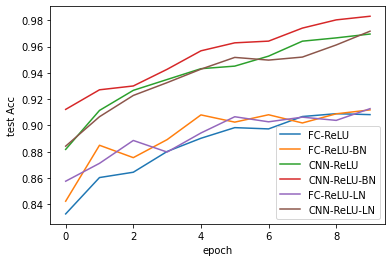

In [35]:
sns.lineplot(x="epoch", y="test Acc", data=fc_relu_results, label="FC-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=fc_bn_results, label="FC-ReLU-BN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_relu_results, label="CNN-ReLU")
sns.lineplot(x="epoch", y="test Acc", data=cnn_bn_results, label="CNN-ReLU-BN")
sns.lineplot(x="epoch", y="test Acc", data=fc_ln_results, label="FC-ReLU-LN")
sns.lineplot(x="epoch", y="test Acc", data=cnn_ln_results, label="CNN-ReLU-LN")

For the
CNN, LN is an improvement over no normalization but worse than BN. 

For the fully
connected layers, LN appears to be more in line with the non-normalized variant.

BN is really only useful for fully connected layers and convolutional
models, so PyTorch can easily hardcode it to the two tasks. 

LN can be helpful for almost
any architecture (e.g., RNNs).